# Preliminary plan for the prestressed bending tests

## Inverted T cross section 

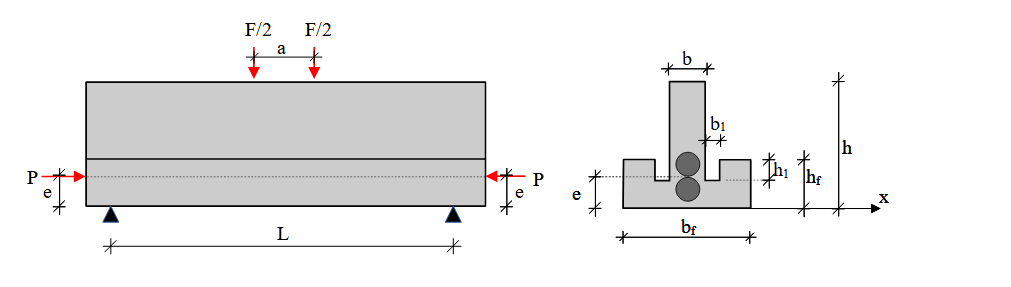

In [22]:
%matplotlib widget
import numpy as np # numerical package
import matplotlib.pyplot as plt # plotting package
import sympy as sp # computer algebra package
sp.init_printing()
import bmcs_utils.api as bu

### Beam dimensions and eccentriciy 

In [23]:
#Beam dimensions
b, h, L, bf, hf, b1, h1  = sp.symbols(r'b, h, L, bf, hf, b1, h1 ', positive=True)

In [24]:
# Compressive strength
fc = sp.symbols(r'f_c', positive=True)

In [25]:
# Eccentricity 
e = sp.symbols(r'e') 

In [26]:
# Distance between applied loading points (four point bending test)
a = sp.symbols(r'a')

#### Maximum eccentricity Determined from the dimensions of the used prestressing 100kN cylinder with dimameter of 70mm

In [27]:
d_cyl = sp.symbols(r'd_cyl')

e_max_ = hf
e_min_ = d_cyl

e_max_, e_min_

### Properties of the cross section
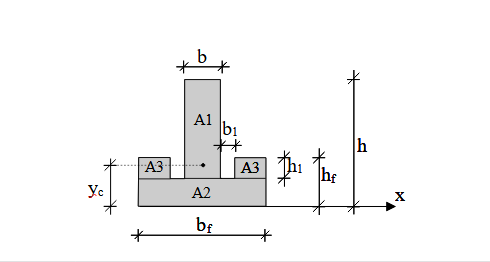

#### Center of gravity

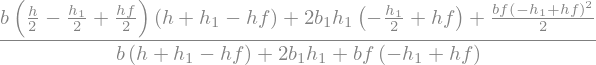

In [28]:
A1 = b * (h - hf + h1)
A2 = bf * (hf - h1) 
A3 = b1 * h1
# centere of gravity of the T section
#yc = (A1 * (hf + (h - hf)/2) + A2* (hf/2) - ) / (A1 + A2)
yc =  (A1 * ((hf-h1)+(h-hf+h1)/2) + A2 * (hf - h1)/2 + 2 * A3 * (hf - h1/2)) / (A1 + A2 + 2 * A3) 
yc

#### Moment of inertia 

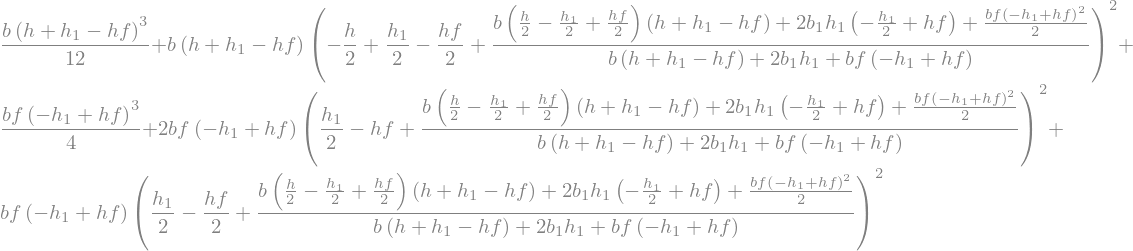

In [29]:
I1 =  b * ((h - hf + h1)**3) / 12

I2 = bf * ((hf-h1)**3)/12

I3 = (((bf - b)/2 - b1) * h1**3) /12

# Moment of inertia of the T section 
I = (I1 + A1 * (yc - ((hf-h1) + (h - hf + h1)/2))**2 + I2 + A2 * (yc - (hf-h1)/2)**2 + 2 * (I2 + A2 *(yc - (hf - h1/2))**2 ))
I

### Resulting stresses 

#### 1. Self weight (g) 

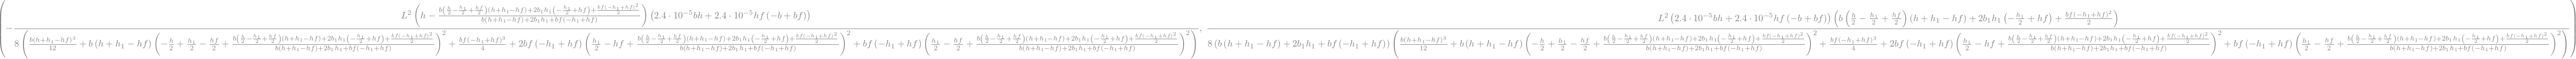

In [30]:
# Self weigth 
q_g = (b * h + (bf-b)*hf)* 24e-6
M_g = q_g * L**2 / 8
q_g,M_g

sigma_g_top = - (M_g / I) * (h - yc)
sigma_g_bot = (M_g / I) * yc

sigma_g_top, sigma_g_bot

#### 2. Prestressing force (pr) 

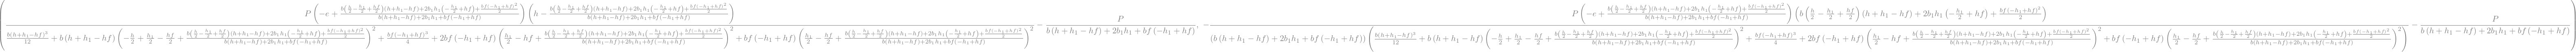

In [31]:
# Prestressing force
P = sp.symbols(r'P', positive=True)

M_pr = P * (yc - e)

sigma_pr_top = - (P / (A1 + A2 + 2 * A3)) + M_pr / (I) * (h - yc)
sigma_pr_bot = - (P / (A1 + A2 + 2 * A3)) - M_pr / (I) *  yc

sigma_pr_top, sigma_pr_bot

#### 3. Vertical force (f) 

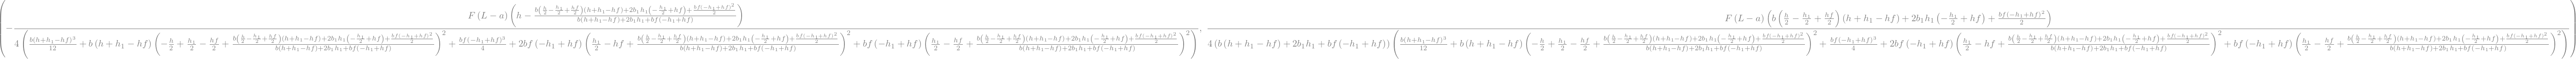

In [32]:
# Vertical force
F = sp.symbols(r'F', positive=True)


M_f = (F/2) *(L-a)/2

sigma_f_top = - M_f / (I) * (h - yc)
sigma_f_bot = M_f / (I) * yc

sigma_f_top, sigma_f_bot

### Plotting stress profiles

In [33]:
class P4PBTExpr(bu.SymbExpr):
    # parameters
    L = L
    a = a
    e = e
    b = b
    h = h
    bf = bf
    hf = hf
    b1 = b1
    h1 = h1
    P = P
    F = F
    d_cyl = d_cyl
    
    e_max_ = e_max_
    e_min_ = e_min_

    A1 = A1
    A2 = A2
    A3 = A3
    yc = yc
    I = I
    
    sigma_f_bot = sigma_f_bot
    sigma_f_top = sigma_f_top
    sigma_pr_bot = sigma_pr_bot
    sigma_pr_top = sigma_pr_top
    sigma_g_bot = sigma_g_bot
    sigma_g_top = sigma_g_top
    
    symb_model_params = ['L', 'b', 'h', 'bf', 'hf', 'b1', 'h1', 'a', 'e', 'P', 'F', 'd_cyl']

    symb_expressions = [
        ('A1', ()),
        ('A2', ()),
        ('A3', ()),
        ('yc', ()),
        ('I', ()),
        
        ('sigma_f_bot', ()),
        ('sigma_f_top', ()),
        ('sigma_pr_bot', ()),
        ('sigma_pr_top', ()),
        ('sigma_g_bot', ()),
        ('sigma_g_top', ()),
    ]

In [34]:
class P4PBT(bu.InteractiveModel, bu.InjectSymbExpr):
    symb_class = P4PBTExpr
    
    L = bu.Float(1200)
    a = bu.Float(300)
    e = bu.Float(70)
    b = bu.Float(100)
    h = bu.Float(250)
    bf = bu.Float(250)
    hf = bu.Float(100)
    b1 = bu.Float(35)
    h1 = bu.Float(35)
    P = bu.Float(400e3)
    F = bu.Float(140e3)
    d_cyl = bu.Float(70)
    fc = bu.Float(30)

    ipw_view = bu.View(
        bu.Item('L'),
        bu.Item('a'),
        bu.Item('e'),
        bu.Item('b'),
        bu.Item('h'),
        bu.Item('bf'),
        bu.Item('hf'),
        bu.Item('b1'),
        bu.Item('h1'),
        bu.Item('P'),
        bu.Item('F'),
        bu.Item('d_cyl'),
        bu.Item('fc')
    )

    def get_sigma(self):
        
        A1 = self.symb.get_A1()
        A2 = self.symb.get_A2()
        A3 = self.symb.get_A3()
        yc = self.symb.get_yc()
        I = self.symb.get_I()
        
        sigma_f_bot = self.symb.get_sigma_f_bot()
        sigma_f_top = self.symb.get_sigma_f_top()
        sigma_pr_bot = self.symb.get_sigma_pr_bot()
        sigma_pr_top = self.symb.get_sigma_pr_top()
        sigma_g_bot = self.symb.get_sigma_g_bot()
        sigma_g_top = self.symb.get_sigma_g_top()

        sigma_g = np.array([ sigma_g_bot, 0, 0, sigma_g_top, sigma_g_bot])
        sigma_pr = np.array([sigma_pr_bot,  0, 0, sigma_pr_top, sigma_pr_bot])
        sigma_f = np.array([sigma_f_bot,  0, 0, sigma_f_top, sigma_f_bot])
        return sigma_g, sigma_pr, sigma_f

    def plot_stress_profiles(self, ax1, ax2, ax3, ax4):
        y = np.array([0, 0, self.h, self.h, 0])
        x_0 = np.array([0, 0, 0, 0, 0])

        sigma_g, sigma_pr, sigma_f = self.get_sigma()
        
        ax1.plot(sigma_g, y , color='black', lw=2)
        ax1.fill_between(sigma_g, y,  x_0, color='black', alpha=0.3)
        ax1.set_xlim(-self.fc/10, self.fc/100)
        ax1.set_xlabel('Stress - self weight')
        ax1.set_ylabel('Height [mm]')

        ax2.plot(sigma_pr, y , color='green', lw=2)
        ax2.fill_between(sigma_pr, y,  x_0, color='green', alpha=0.3)
        ax2.set_xlim(-self.fc, self.fc/10)
        ax2.set_xlabel('Stress - prestressing force (P)')

        ax3.plot(sigma_f, y , color='blue', lw=2)
        ax3.fill_between(sigma_f, y,  x_0, color='blue', alpha=0.3)
        ax3.set_xlim(-self.fc, self.fc)
        ax3.set_xlabel('Stress - vertical loading (F)')

        ax4.plot(sigma_g + sigma_pr + sigma_f, y , color='red', lw=2, label='loading')
        ax4.plot(sigma_g + sigma_pr, y , "--r", lw=1, label='unloading')
        ax4.fill_between(sigma_g + sigma_pr + sigma_f, y,  x_0, color='red', alpha=0.3)
        ax4.set_xlim(-self.fc, self.fc/10)
        ax4.set_xlabel('Sum of stresses')
        ax4.legend(loc=1)
        
    def plot_normalized_stress_profiles(self, ax1, ax2, ax3, ax4):
        y = np.array([0, 0, self.h, self.h, 0])
        x_0 = np.array([0, 0, 0, 0, 0])

        sigma_g, sigma_pr, sigma_f = self.get_sigma()
        
        ax1.plot(sigma_g/self.fc, y , color='black', lw=2)
        ax1.fill_between(sigma_g/self.fc, y,  x_0, color='black', alpha=0.3)
        ax1.set_xlabel('self weight')
        ax1.set_xlim(-1/10, 1/100)
        ax1.set_ylabel('Height [mm]')

        ax2.plot(sigma_pr/self.fc, y , color='green', lw=2)
        ax2.fill_between(sigma_pr/self.fc, y,  x_0, color='green', alpha=0.3)
        ax2.set_xlim(-1, 1/10)
        ax2.set_xlabel('prestressing')

        ax3.plot(sigma_f/self.fc, y , color='blue', lw=2)
        ax3.fill_between(sigma_f/self.fc, y,  x_0, color='blue', alpha=0.3)
        ax3.set_xlim(-1, 1)
        ax3.set_xlabel('vertical loading')

        ax4.plot((sigma_g + sigma_pr + sigma_f)/self.fc, y , color='red', lw=2, label='loading')
        ax4.plot((sigma_g + sigma_pr)/self.fc , y, "--r", lw=1, label='loading')
        ax4.fill_between((sigma_g + sigma_pr + sigma_f)/self.fc, y,  x_0, color='red', alpha=0.3)
        ax4.set_xlim(-1, 1/10)
        ax4.set_xlabel('Sum of normalized stresses')
        ax4.legend(loc=1)
    
    def subplots(self, fig):
        return fig.subplots(1,4)

    def update_plot(self, axes):
        ax1, ax2, ax3, ax4 = axes
        #self.plot_stress_profiles(ax1, ax2, ax3, ax4)
        self.plot_normalized_stress_profiles(ax1, ax2, ax3, ax4)
        
    def report(self):
        sigma_g, sigma_pr, sigma_f = self.get_sigma()

        print("Stress ratios at top")
        print("Loading stage: Smax =", np.around(-(sigma_g + sigma_pr + sigma_f)[3]/self.fc,2))
        print("Loading stage: Smin =",  np.around(-(sigma_g + sigma_pr)[3]/self.fc, 2))
        print("Loading stage: Amplitude =", np.around(-(sigma_g + sigma_pr + sigma_f)[3]/self.fc + 
                                                      (sigma_g + sigma_pr)[3]/self.fc, 2))
        print("*****************")


        print("Stress ratios at bottom")
        print("Unloading stage: Smax =", np.around(-(sigma_g + sigma_pr)[0]/self.fc,2))
        print("Unloading stage: Smin =", np.around(-(sigma_g + sigma_pr + sigma_f)[0]/self.fc, 2))
        print("Loading stage: Amplitude =", np.around(+(sigma_g + sigma_pr + sigma_f)[0]/self.fc - 
                                                      (sigma_g + sigma_pr)[0]/self.fc, 2))


In [35]:
p4pbt = P4PBT()

In [36]:
p4pbt.interact()

In [16]:
p4pbt.report()

Stress ratios at top
Loading stage: Smax = 0.85
Loading stage: Smin = 0.1
Loading stage: Amplitude = 0.75
*****************
Stress ratios at bottom
Unloading stage: Smax = 0.53
Unloading stage: Smin = 0.04
Loading stage: Amplitude = 0.48
